# AI 201 Mini Project
## Coffee Match: Leveraging Machine Learning for Coffee Bean Recommendations Using Taste Profiles
### Recommender Model Implementation

Submitted by: 
Jan Lendl R. Uy, 2019-00312

In [152]:
%pip install scikit-learn numpy pandas optuna tqdm plotly

Note: you may need to restart the kernel to use updated packages.


In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
import optuna
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

## Load the cleaned dataset

### Cleaned dataset

In [154]:
# Read the cleaned dataset
user_item_df = pd.read_csv('datasets/preprocessed_coffee_data.csv')

## Generate the user-item matrices

In [155]:
import pandas as pd
import numpy as np

def create_numpy_interaction_matrix(user_item_df):
    """
    Convert user-item-rating dataframe into a numpy interaction matrix and create index mappings.
    
    Parameters:
    user_item_df (pandas.DataFrame): Dataframe with columns [user, item, rating]
    
    Returns:
    tuple: (interaction_matrix, user_to_idx, idx_to_user, item_to_idx, idx_to_item)
        - interaction_matrix: numpy array of ratings
        - user_to_idx: dict mapping usernames to matrix row indices
        - idx_to_user: dict mapping row indices to usernames
        - item_to_idx: dict mapping item names to matrix column indices
        - idx_to_item: dict mapping column indices to item names
    """
    # Create the pivot table without including 'user' as an item
    interaction_df = pd.pivot_table(
        user_item_df,
        values='rating',
        index='user',
        columns='item',
        fill_value=np.nan
    )
    
    # Create bidirectional mappings for users and items
    user_to_idx = {user: idx for idx, user in enumerate(interaction_df.index)}
    idx_to_user = {idx: user for user, idx in user_to_idx.items()}
    
    item_to_idx = {item: idx for idx, item in enumerate(interaction_df.columns)}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}
    
    # Convert to numpy array
    interaction_matrix = interaction_df.values
    
    # Print matrix information
    print(f"Matrix shape: {interaction_matrix.shape}")
    print(f"Number of users: {len(user_to_idx)}")
    print(f"Number of items: {len(item_to_idx)}")
    print(f"Non-null values: {np.count_nonzero(~np.isnan(interaction_matrix))}")
    
    return interaction_matrix, user_to_idx, idx_to_user, item_to_idx, idx_to_item

def get_user_ratings(user_id, interaction_matrix, user_to_idx, idx_to_item):
    """
    Example function showing how to use the mappings to get a user's ratings.
    """
    user_idx = user_to_idx[user_id]
    user_ratings = interaction_matrix[user_idx]
    
    # Create a dictionary of item names and their ratings
    ratings_dict = {
        idx_to_item[idx]: rating 
        for idx, rating in enumerate(user_ratings) 
        if not np.isnan(rating)
    }
    
    return ratings_dict

user_item_matrix, user_to_idx, idx_to_user, item_to_idx, idx_to_item = create_numpy_interaction_matrix(user_item_df)

Matrix shape: (24, 119)
Number of users: 24
Number of items: 119
Non-null values: 164


In [156]:
items = idx_to_item.values()

In [157]:
get_user_ratings('user_14', user_item_matrix, user_to_idx, idx_to_item)

{'Honduras_Catimor_Washed/Wet': np.float64(81.58),
 'Honduras_Catuai_Natural/Dry': np.float64(81.69666666666667),
 'Honduras_Catuai_Washed/Wet': np.float64(79.65333333333334),
 'Honduras_Caturra_Natural/Dry': np.float64(81.88),
 'Honduras_Caturra_Washed/Wet': np.float64(82.18181818181819),
 'Honduras_Pacas_Natural/Dry': np.float64(77.0),
 'Honduras_Pacas_Washed/Wet': np.float64(76.21000000000001),
 'Nicaragua_Caturra_Washed/Wet': np.float64(81.83500000000001)}

## Split the dataset into training and test sets

In [158]:
import numpy as np
from sklearn.model_selection import train_test_split

def split_interaction_matrix_exact(interaction_matrix, test_size=0.2, 
                                 min_ratings_per_user=2, random_state=None):
    """
    Split interaction matrix into training and test sets while maintaining exact test percentage.
    
    Parameters:
    interaction_matrix (numpy.ndarray): User-item interaction matrix
    test_size (float): Target proportion of ratings to use for testing (0 to 1)
    min_ratings_per_user (int): Minimum number of ratings per user to keep in training
    random_state (int): Random seed for reproducibility
    
    Returns:
    tuple: (train_matrix, test_matrix)
    """
    np.random.seed(random_state)
    n_users, n_items = interaction_matrix.shape
    
    # Initialize matrices
    train_matrix = np.full_like(interaction_matrix, np.nan)
    test_matrix = np.full_like(interaction_matrix, np.nan)
    
    # Get all rated positions
    rated_positions = np.where(~np.isnan(interaction_matrix))
    total_ratings = len(rated_positions[0])
    
    # Create array of all ratings with their positions
    all_ratings = list(zip(rated_positions[0], rated_positions[1]))
    
    # Count ratings per user
    ratings_per_user = {}
    for user_idx in range(n_users):
        user_ratings = np.where(~np.isnan(interaction_matrix[user_idx]))[0]
        ratings_per_user[user_idx] = len(user_ratings)
    
    # Calculate target number of test ratings
    target_test_ratings = int(total_ratings * test_size)
    
    # First, ensure minimum training ratings for each user
    for user_idx, n_ratings in ratings_per_user.items():
        if n_ratings > 0:
            user_positions = [(i, j) for i, j in all_ratings if i == user_idx]
            
            # Randomly select minimum training ratings
            n_train = min(min_ratings_per_user, n_ratings)
            train_positions = np.random.choice(len(user_positions), 
                                            size=n_train, 
                                            replace=False)
            
            # Add these positions to training set
            for pos_idx in train_positions:
                i, j = user_positions[pos_idx]
                train_matrix[i, j] = interaction_matrix[i, j]
                all_ratings.remove((i, j))
    
    # Now distribute remaining ratings to maintain exact test percentage
    remaining_ratings = len(all_ratings)
    remaining_test_ratings = min(target_test_ratings, remaining_ratings)
    
    # Randomly select test ratings from remaining ratings
    test_indices = np.random.choice(remaining_ratings, 
                                  size=remaining_test_ratings, 
                                  replace=False)
    
    # Distribute remaining ratings
    for idx, (i, j) in enumerate(all_ratings):
        if idx in test_indices:
            test_matrix[i, j] = interaction_matrix[i, j]
        else:
            train_matrix[i, j] = interaction_matrix[i, j]
    
    # Calculate actual split percentages
    train_ratings = np.count_nonzero(~np.isnan(train_matrix))
    test_ratings = np.count_nonzero(~np.isnan(test_matrix))
    actual_test_size = test_ratings / (train_ratings + test_ratings)
    
    # Print detailed split information
    print("\nSplit Statistics:")
    print("-" * 50)
    print(f"Total ratings: {total_ratings}")
    print(f"Training ratings: {train_ratings} ({train_ratings/total_ratings:.1%})")
    print(f"Testing ratings: {test_ratings} ({test_ratings/total_ratings:.1%})")
    # print(f"Target test size: {test_size:.1%}")
    # print(f"Actual test size: {actual_test_size:.1%}")
    
    # Print per-user statistics
    train_per_user = np.count_nonzero(~np.isnan(train_matrix), axis=1)
    test_per_user = np.count_nonzero(~np.isnan(test_matrix), axis=1)
    
    # print("\nPer-User Statistics:")
    # print("-" * 50)
    # print(f"Average training ratings per user: {np.mean(train_per_user):.1f}")
    # print(f"Average test ratings per user: {np.mean(test_per_user):.1f}")
    # print(f"Minimum training ratings per user: {np.min(train_per_user[train_per_user > 0])}")
    
    return train_matrix, test_matrix

# Example usage:
train_matrix, test_matrix = split_interaction_matrix_exact(
    user_item_matrix,
    test_size=0.2,
    min_ratings_per_user=2,
    random_state=0
)


Split Statistics:
--------------------------------------------------
Total ratings: 164
Training ratings: 132 (80.5%)
Testing ratings: 32 (19.5%)


## Recommender System Implementation

In [159]:
import numpy as np
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import StandardScaler

class CoffeeRecommender:
    """
    Base class for matrix factorization-based recommender systems.
    """
    def __init__(self, n_factors=10, random_state=None):
        self.n_factors = n_factors
        self.random_state = random_state
        self.model = None
        self.scaler = StandardScaler()
        self.user_features = None
        self.item_features = None
        self.global_mean = None
    
    def _preprocess(self, matrix):
        """
        Preprocess the rating matrix by filling missing values and scaling.
        """
        # Store the global mean of non-NaN values
        self.global_mean = np.nanmean(matrix)
        
        # Fill NaN with global mean for scaling
        filled_matrix = np.nan_to_num(matrix, nan=self.global_mean)
        
        # Scale the data
        scaled_matrix = self.scaler.fit_transform(filled_matrix)
        return scaled_matrix
    
    def _postprocess(self, predictions):
        """
        Postprocess predictions by rescaling them back to original scale.
        No longer reintroduces NaN values.
        """
        # Inverse transform the scaled predictions
        rescaled_predictions = self.scaler.inverse_transform(predictions)
        return rescaled_predictions

class SVDRecommender(CoffeeRecommender):
    def __init__(self, n_factors=100, random_state=None):
        super().__init__(n_factors=n_factors, random_state=random_state)
        self.model = TruncatedSVD(
            n_components=n_factors,
            random_state=random_state
        )
        # Initialize matrices as None
        self.U = None
        self.sigma = None
        self.Vt = None
    
    def fit(self, train_matrix):
        """
        Train the SVD model and store U, sigma, and Vt matrices.
        """
        processed_matrix = self._preprocess(train_matrix)
        
        # Fit the model and get matrices
        self.U = self.model.fit_transform(processed_matrix)
        self.Vt = self.model.components_
        self.sigma = self.model.singular_values_
        
        # Store these for the prediction step
        self.user_features = self.U
        self.item_features = self.Vt
        
        explained_var_ratio = self.model.explained_variance_ratio_
        print(f"\nSVD Model Information:")
        print("-" * 50)
        print(f"Number of components: {self.n_factors}")
        print(f"Total explained variance: {np.sum(explained_var_ratio):.3f}")
        
        # Print matrix shapes for verification
        print(f"U matrix shape: {self.U.shape}")
        print(f"sigma vector length: {len(self.sigma)}")
        print(f"Vt matrix shape: {self.Vt.shape}")
    
    def get_matrices(self):
        """
        Return the factorized matrices.
        """
        return self.U, self.sigma, self.Vt
    
    def predict(self, test_matrix):
        """
        Generate predictions for all user-item pairs.
        Now returns predictions for all positions, including previously missing ones.
        """
        processed_matrix = self._preprocess(test_matrix)
        predictions = self.model.inverse_transform(self.user_features)
        return self._postprocess(predictions)

class NMFRecommender(CoffeeRecommender):
    def __init__(self, n_factors=100, random_state=None):
        super().__init__(n_factors=n_factors, random_state=random_state)
        self.model = NMF(
            n_components=n_factors,
            init='nndsvd',
            random_state=random_state,
            max_iter=1000
        )
        # Initialize matrices as None
        self.W = None
        self.H = None
    
    def fit(self, train_matrix):
        """
        Train the NMF model and store W and H matrices.
        """
        processed_matrix = self._preprocess(train_matrix)
        processed_matrix = np.maximum(processed_matrix, 0)  # Ensure non-negativity
        
        # Fit the model and get matrices
        self.W = self.model.fit_transform(processed_matrix)
        self.H = self.model.components_
        
        # Store these for the prediction step
        self.user_features = self.W
        self.item_features = self.H
        
        print(f"\nNMF Model Information:")
        print("-" * 50)
        print(f"Number of components: {self.n_factors}")
        print(f"Reconstruction error: {self.model.reconstruction_err_:.3f}")
        
        # Print matrix shapes for verification
        print(f"W matrix shape: {self.W.shape}")
        print(f"H matrix shape: {self.H.shape}")
    
    def get_matrices(self):
        """
        Return the factorized matrices.
        """
        return self.W, self.H
    
    def predict(self, test_matrix):
        """
        Generate predictions for all user-item pairs.
        Now returns predictions for all positions, including previously missing ones.
        """
        processed_matrix = self._preprocess(test_matrix)
        predictions = self.user_features @ self.item_features
        return self._postprocess(predictions)

In [160]:
import numpy as np
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(predictions, actual):
    """
    Calculate both RMSE and MAE for the predictions.
    
    Parameters:
    predictions (numpy.ndarray): Predicted ratings
    actual (numpy.ndarray): Actual ratings
    
    Returns:
    tuple: (rmse, mae)
    """
    # Create mask for positions where we have actual ratings
    mask = ~np.isnan(actual)
    
    # Extract relevant predictions and actual values
    valid_predictions = predictions[mask]
    valid_actual = actual[mask]
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(valid_actual, valid_predictions))
    mae = mean_absolute_error(valid_actual, valid_predictions)
    
    # Print detailed information about the predictions
    print(f"Number of test positions: {np.sum(mask)}")
    print(f"Average prediction value: {np.mean(valid_predictions):.3f}")
    print(f"Average actual value: {np.mean(valid_actual):.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    
    return rmse, mae

def train_and_evaluate_models(train_matrix, test_matrix, n_factors=10, random_state=0):
    """
    Train and evaluate both SVD and NMF models with both RMSE and MAE metrics.
    """
    # Initialize models
    svd_model = SVDRecommender(n_factors=n_factors, random_state=random_state)
    nmf_model = NMFRecommender(n_factors=n_factors, random_state=random_state)
    
    # Dictionary to store all metrics
    metrics = {
        'SVD': {},
        'NMF': {}
    }
    
    # Train and evaluate SVD
    print("\nTraining SVD Model...")
    t0 = time.time()
    svd_model.fit(train_matrix)
    svd_time = time.time() - t0
    
    print("\nGenerating SVD Predictions...")
    svd_predictions = svd_model.predict(test_matrix)
    print("\nSVD Performance:")
    svd_rmse, svd_mae = calculate_metrics(svd_predictions, test_matrix)
    
    metrics['SVD'] = {
        'RMSE': svd_rmse,
        'MAE': svd_mae,
        'Training Time': svd_time
    }
    
    # Train and evaluate NMF
    print("\nTraining NMF Model...")
    t0 = time.time()
    nmf_model.fit(train_matrix)
    nmf_time = time.time() - t0
    
    print("\nGenerating NMF Predictions...")
    nmf_predictions = nmf_model.predict(test_matrix)
    print("\nNMF Performance:")
    nmf_rmse, nmf_mae = calculate_metrics(nmf_predictions, test_matrix)
    
    metrics['NMF'] = {
        'RMSE': nmf_rmse,
        'MAE': nmf_mae,
        'Training Time': nmf_time
    }
    
    # Print comparison table
    print("\nModel Performance Summary:")
    print("-" * 60)
    print(f"{'Model':<10} {'RMSE':>10} {'MAE':>10} {'Training Time':>15}")
    print("-" * 60)
    for model in ['SVD', 'NMF']:
        print(f"{model:<10} {metrics[model]['RMSE']:>10.3f} {metrics[model]['MAE']:>10.3f} {metrics[model]['Training Time']:>15.4f}s")
    
    return svd_model, nmf_model, svd_predictions, nmf_predictions, metrics

def analyze_factors_impact(train_matrix, test_matrix, factors_range, random_state=0):
    """
    Analyze the impact of different numbers of components on model performance,
    now including both RMSE and MAE metrics.
    """
    
    # Dictionary to store results
    results = {
        'n_factors': [],
        'svd_rmse': [], 'svd_mae': [], 'svd_time': [],
        'nmf_rmse': [], 'nmf_mae': [], 'nmf_time': []
    }
    
    for n_factors in factors_range:
        print(f"\nTesting with {n_factors} components:")
        _, _, _, _, metrics = train_and_evaluate_models(
            train_matrix,
            test_matrix,
            n_factors=n_factors,
            random_state=random_state
        )
        
        # Store results
        results['n_factors'].append(n_factors)
        results['svd_rmse'].append(metrics['SVD']['RMSE'])
        results['svd_mae'].append(metrics['SVD']['MAE'])
        results['svd_time'].append(metrics['SVD']['Training Time'])
        results['nmf_rmse'].append(metrics['NMF']['RMSE'])
        results['nmf_mae'].append(metrics['NMF']['MAE'])
        results['nmf_time'].append(metrics['NMF']['Training Time'])
    
    # Create plots for both metrics
    plt.figure(figsize=(15, 5))
    
    # RMSE plot
    plt.subplot(1, 2, 1)
    plt.plot(results['n_factors'], results['svd_rmse'], 'o-', label='SVD')
    plt.plot(results['n_factors'], results['nmf_rmse'], 's-', label='NMF')
    plt.xlabel('Number of Components\n(lower is better)')
    plt.xticks([i for i in range(2, 21, 2)])
    plt.ylabel('RMSE')
    plt.ylim(1.99, 2.03)
    plt.title('RMSE vs Number of Components')
    plt.legend()
    plt.grid(True)
    
    # MAE plot
    plt.subplot(1, 2, 2)
    plt.plot(results['n_factors'], results['svd_mae'], 'o-', label='SVD')
    plt.plot(results['n_factors'], results['nmf_mae'], 's-', label='NMF')
    plt.xlabel('Number of Components\n(lower is better)')
    plt.xticks([i for i in range(2, 21, 2)])
    plt.ylabel('MAE')
    plt.ylim(1.55, 1.58)
    plt.title('MAE vs Number of Components')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(results)

### Check implementation of recommender systems

In [161]:
svd_rec = SVDRecommender(n_factors=20)
svd_rec.fit(train_matrix)
svd_predictions = svd_rec.predict(test_matrix)

nmf_rec = NMFRecommender(n_factors=20)
nmf_rec.fit(train_matrix)
nmf_predictions = nmf_rec.predict(test_matrix)


SVD Model Information:
--------------------------------------------------
Number of components: 20
Total explained variance: 0.970
U matrix shape: (24, 20)
sigma vector length: 20
Vt matrix shape: (20, 119)

NMF Model Information:
--------------------------------------------------
Number of components: 20
Reconstruction error: 0.681
W matrix shape: (24, 20)
H matrix shape: (20, 119)


### Determine the effect of components


Testing with 2 components:

Training SVD Model...

SVD Model Information:
--------------------------------------------------
Number of components: 2
Total explained variance: 0.356
U matrix shape: (24, 2)
sigma vector length: 2
Vt matrix shape: (2, 119)

Generating SVD Predictions...

SVD Performance:
Number of test positions: 32
Average prediction value: 82.656
Average actual value: 82.634
RMSE: 2.013
MAE: 1.568

Training NMF Model...

NMF Model Information:
--------------------------------------------------
Number of components: 2
Reconstruction error: 27.881
W matrix shape: (24, 2)
H matrix shape: (2, 119)

Generating NMF Predictions...

NMF Performance:
Number of test positions: 32
Average prediction value: 82.652
Average actual value: 82.634
RMSE: 2.010
MAE: 1.562

Model Performance Summary:
------------------------------------------------------------
Model            RMSE        MAE   Training Time
------------------------------------------------------------
SVD             2.01

/Users/lendluy/Documents/MEngg AI/AI 201 2nd Take/ai201/mini_project/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


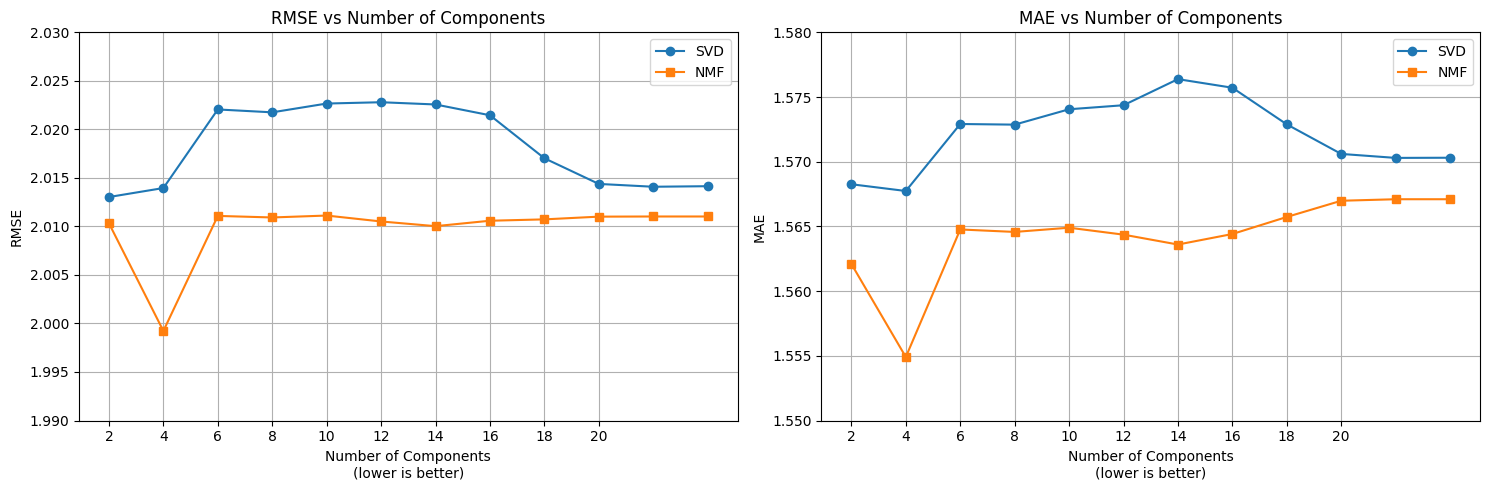

In [162]:
results_df = analyze_factors_impact(
    train_matrix,
    test_matrix,
    factors_range=[i for i in range(2, 25, 2)]
)

## Analysis

In [163]:
# For SVD
svd_model = SVDRecommender(n_factors=4)
svd_model.fit(train_matrix)
U, sigma, Vt = svd_model.get_matrices()

# For NMF
nmf_model = NMFRecommender(n_factors=4)
nmf_model.fit(train_matrix)
W, H = nmf_model.get_matrices()


SVD Model Information:
--------------------------------------------------
Number of components: 4
Total explained variance: 0.494
U matrix shape: (24, 4)
sigma vector length: 4
Vt matrix shape: (4, 119)

NMF Model Information:
--------------------------------------------------
Number of components: 4
Reconstruction error: 24.523
W matrix shape: (24, 4)
H matrix shape: (4, 119)


In [164]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_svd_components(U, sigma, Vt, idx_to_user, idx_to_item, n_top=10):
    """
    Analyze and interpret SVD components for the coffee recommendation system.
    
    Parameters:
    U: User-factor matrix from SVD
    sigma: Singular values
    Vt: Transposed item-factor matrix from SVD
    idx_to_user: Dictionary mapping indices to user IDs
    idx_to_item: Dictionary mapping indices to coffee items
    n_top: Number of top items to show for each component
    """
    n_components = len(sigma)
    
    # Calculate variance explained by each component
    total_variance = np.sum(sigma**2)
    variance_ratios = (sigma**2) / total_variance
    
    print("SVD Component Analysis")
    print("=" * 50)
    print("\nVariance Explained by Components:")
    for i, var in enumerate(variance_ratios):
        print(f"Component {i+1}: {var*100:.2f}% variance explained")
    
    # Analyze each component
    for comp_idx in range(n_components):
        print(f"\nComponent {comp_idx + 1} Analysis:")
        print("-" * 30)
        
        # Get item loadings for this component
        item_loadings = Vt[comp_idx]
        
        # Find top positive and negative items
        top_pos_idx = np.argsort(item_loadings)[-n_top:]
        top_neg_idx = np.argsort(item_loadings)[:n_top]
        
        # Extract coffee characteristics
        def parse_coffee_name(name):
            origin, variety, process = name.split('_')
            return origin, variety, process
        
        # Analyze top positive items
        print("\nTop Positive Association Coffees:")
        pos_characteristics = {'origin': [], 'variety': [], 'process': []}
        for idx in top_pos_idx[::-1]:  # Reverse to show highest first
            coffee_name = idx_to_item[idx]
            origin, variety, process = parse_coffee_name(coffee_name)
            pos_characteristics['origin'].append(origin)
            pos_characteristics['variety'].append(variety)
            pos_characteristics['process'].append(process)
            print(f"{coffee_name}: {item_loadings[idx]:.3f}")
        
        # Analyze top negative items
        print("\nTop Negative Association Coffees:")
        neg_characteristics = {'origin': [], 'variety': [], 'process': []}
        for idx in top_neg_idx:
            coffee_name = idx_to_item[idx]
            origin, variety, process = parse_coffee_name(coffee_name)
            neg_characteristics['origin'].append(origin)
            neg_characteristics['variety'].append(variety)
            neg_characteristics['process'].append(process)
            print(f"{coffee_name}: {item_loadings[idx]:.3f}")
        
        # Analyze patterns in characteristics
        print("\nCharacteristic Patterns:")
        for char_type in ['origin', 'variety', 'process']:
            pos_common = pd.Series(pos_characteristics[char_type]).value_counts()
            neg_common = pd.Series(neg_characteristics[char_type]).value_counts()
            
            if len(pos_common) > 0:
                print(f"\nMost common {char_type} in positive associations:")
                print(pos_common.head())
            if len(neg_common) > 0:
                print(f"\nMost common {char_type} in negative associations:")
                print(neg_common.head())
        
        # Analyze user preferences for this component
        user_loadings = U[:, comp_idx]
        top_users_idx = np.argsort(np.abs(user_loadings))[-5:]  # Top 5 users by magnitude
        
        print("\nUser Preferences for this Component:")
        for idx in top_users_idx[::-1]:
            user_name = idx_to_user[idx]
            print(f"{user_name}: {user_loadings[idx]:.3f}")

def analyze_nmf_components(W, H, idx_to_user, idx_to_item, n_top=10):
    """
    Analyze and interpret NMF components for the coffee recommendation system.
    
    Parameters:
    W: User-factor matrix from NMF
    H: Factor-item matrix from NMF
    idx_to_user: Dictionary mapping indices to user IDs
    idx_to_item: Dictionary mapping indices to coffee items
    n_top: Number of top items to show for each component
    """
    n_components = W.shape[1]
    
    print("NMF Component Analysis")
    print("=" * 50)
    
    # Calculate relative importance of components
    component_importance = np.sum(H, axis=1)
    total_importance = np.sum(component_importance)
    
    print("\nComponent Importance:")
    for i, imp in enumerate(component_importance):
        print(f"Component {i+1}: {(imp/total_importance)*100:.2f}% relative importance")
    
    # Analyze each component
    for comp_idx in range(n_components):
        print(f"\nComponent {comp_idx + 1} Analysis:")
        print("-" * 30)
        
        # Get item weights for this component
        item_weights = H[comp_idx]
        
        # Find top items
        top_idx = np.argsort(item_weights)[-n_top:]
        
        # Extract coffee characteristics
        def parse_coffee_name(name):
            origin, variety, process = name.split('_')
            return origin, variety, process
        
        # Analyze top items
        print("\nTop Representative Coffees:")
        characteristics = {'origin': [], 'variety': [], 'process': []}
        for idx in top_idx[::-1]:  # Reverse to show highest first
            coffee_name = idx_to_item[idx]
            origin, variety, process = parse_coffee_name(coffee_name)
            characteristics['origin'].append(origin)
            characteristics['variety'].append(variety)
            characteristics['process'].append(process)
            print(f"{coffee_name}: {item_weights[idx]:.3f}")
        
        # Analyze patterns in characteristics
        print("\nCharacteristic Patterns:")
        for char_type in ['origin', 'variety', 'process']:
            common = pd.Series(characteristics[char_type]).value_counts()
            if len(common) > 0:
                print(f"\nMost common {char_type}:")
                print(common.head())
        
        # Analyze user preferences for this component
        user_weights = W[:, comp_idx]
        top_users_idx = np.argsort(user_weights)[-5:]  # Top 5 users
        
        print("\nUser Preferences for this Component:")
        for idx in top_users_idx[::-1]:
            user_name = idx_to_user[idx]
            print(f"{user_name}: {user_weights[idx]:.3f}")

def visualize_component_patterns(matrix, idx_to_item, component_idx, title):
    """
    Create a visualization of coffee characteristics for a specific component,
    preserving relationships between origins, varieties, and processing methods.
    """
    plt.figure(figsize=(15, 6))
    
    # Get weights for the component
    weights = matrix[component_idx]
    
    # Create DataFrame with coffee characteristics and weights
    coffee_data = []
    for idx, weight in enumerate(weights):
        coffee_name = idx_to_item[idx]
        origin, variety, process = coffee_name.split('_')
        coffee_data.append({
            'coffee_id': idx,
            'origin': origin,
            'variety': variety,
            'process': process,
            'weight': weight,
            'combination': f"{origin}_{variety}"  # Track origin-variety combinations
        })
    
    df = pd.DataFrame(coffee_data)
    
    # Calculate weighted averages considering relationships
    origin_weights = (
        df.groupby('origin')
        .agg({
            'weight': ['mean', 'count', 'std']
        })
        .sort_values(('weight', 'mean'), ascending=True)
    )
    
    variety_weights = (
        df.groupby(['variety', 'origin'])
        .agg({
            'weight': ['mean', 'count']
        })
        .reset_index()
        .sort_values(('weight', 'mean'), ascending=True)
    )
    
    process_weights = (
        df.groupby('process')
        .agg({
            'weight': ['mean', 'count', 'std']
        })
        .sort_values(('weight', 'mean'), ascending=True)
    )
    
    plt.subplot(131)
    origin_weights[('weight', 'mean')].plot(kind='barh',
        alpha=0.8)
    plt.title('Average Weight by Origin')
    
    # Plot varieties with their corresponding origins
    plt.subplot(132)
    variety_pivot = variety_weights.pivot(
        index='variety', 
        columns='origin', 
        values=('weight', 'mean')
    ).fillna(0)
    variety_pivot.sum(axis=1).sort_values().plot(kind='barh')
    plt.title('Average Weight by Variety')
    
    plt.subplot(133)
    process_weights[('weight', 'mean')].plot(kind='barh',
        alpha=0.8)
    plt.title('Average Weight by Process')
    
    plt.suptitle(f'{title} - Latent Factor {component_idx + 1}')
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\nDetailed Statistics:")
    print("\nTop Origin-Variety Combinations:")
    top_combinations = (
        df.groupby(['origin', 'variety'])['weight']
        .agg(['mean', 'count'])
        .sort_values('mean', ascending=False)
        .head(10)
    )
    print(top_combinations)

In [165]:
# For SVD:
analyze_svd_components(U, sigma, Vt, idx_to_user, idx_to_item)

# For NMF:
analyze_nmf_components(W, H, idx_to_user, idx_to_item)


SVD Component Analysis

Variance Explained by Components:
Component 1: 52.68% variance explained
Component 2: 19.28% variance explained
Component 3: 14.30% variance explained
Component 4: 13.74% variance explained

Component 1 Analysis:
------------------------------

Top Positive Association Coffees:
UnitedStates_HawaiianKona_Natural/Dry: 0.192
Brazil_Bourbon_Natural/Dry: 0.192
UnitedStates_HawaiianKona_Washed/Wet: 0.192
Taiwan_YellowBourbon_Washed/Wet: 0.192
Indonesia_Mandheling_Semi-Washed/Semi-Pulped: 0.192
Brazil_Bourbon_Washed/Wet: 0.192
Vietnam_Caturra_Washed/Wet: 0.192
Philippines_Typica_Natural/Dry: 0.192
CostaRica_Catuai_Washed/Wet: 0.175
Brazil_YellowBourbon_Semi-Washed/Semi-Pulped: 0.145

Top Negative Association Coffees:
Indonesia_Sumatra_Semi-Washed/Semi-Pulped: -0.192
Taiwan_Bourbon_Semi-Washed/Semi-Pulped: -0.192
CostaRica_Bourbon_Semi-Washed/Semi-Pulped: -0.192
ElSalvador_Bourbon_Natural/Dry: -0.192
Taiwan_Bourbon_Washed/Wet: -0.192
Burundi_Bourbon_Washed/Wet: -0.192
V

### SVD Latent Factors Analysis

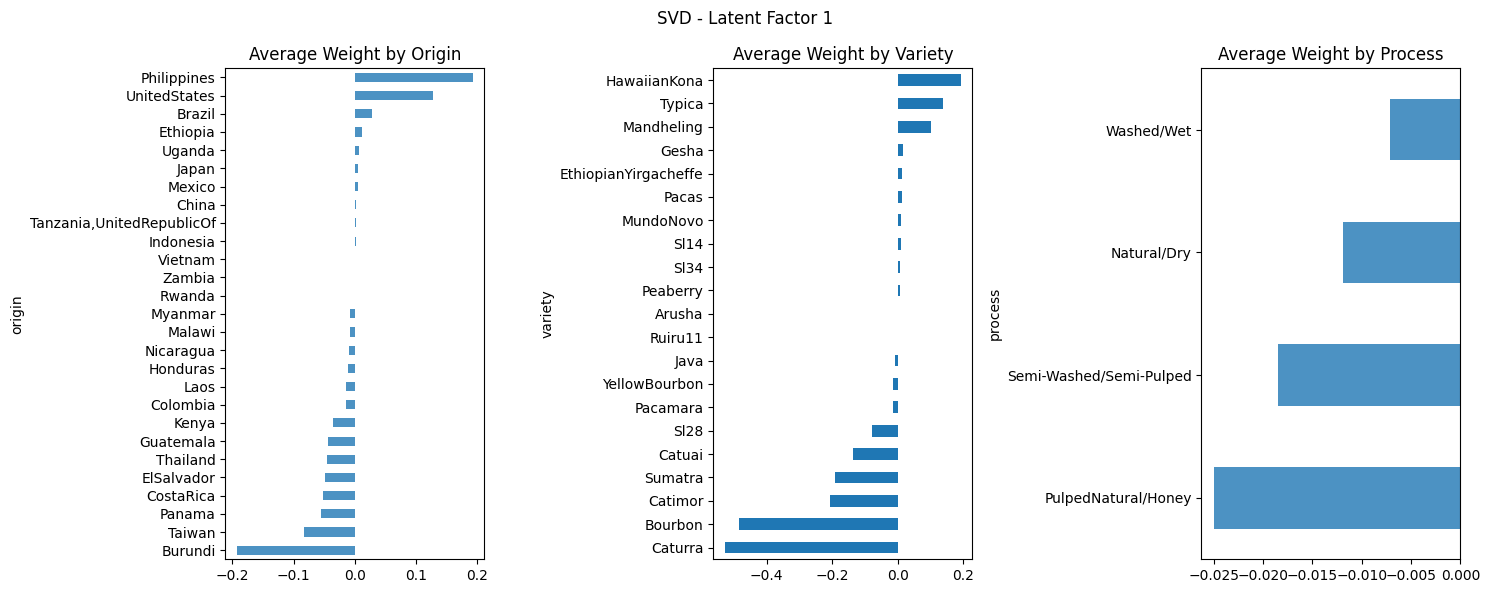


Detailed Statistics:

Top Origin-Variety Combinations:
                                       mean  count
origin       variety                              
UnitedStates HawaiianKona          0.191902      2
Philippines  Typica                0.191902      1
Vietnam      Caturra               0.191902      1
Brazil       Bourbon               0.111532      4
Indonesia    Mandheling            0.100496      2
CostaRica    Catuai                0.087516      2
Mexico       Bourbon               0.058091      2
Ethiopia     EthiopianYirgacheffe  0.013801      2
Panama       Caturra               0.013801      1
Ethiopia     Gesha                 0.012568      1


In [166]:
visualize_component_patterns(Vt, idx_to_item, 0, "SVD")

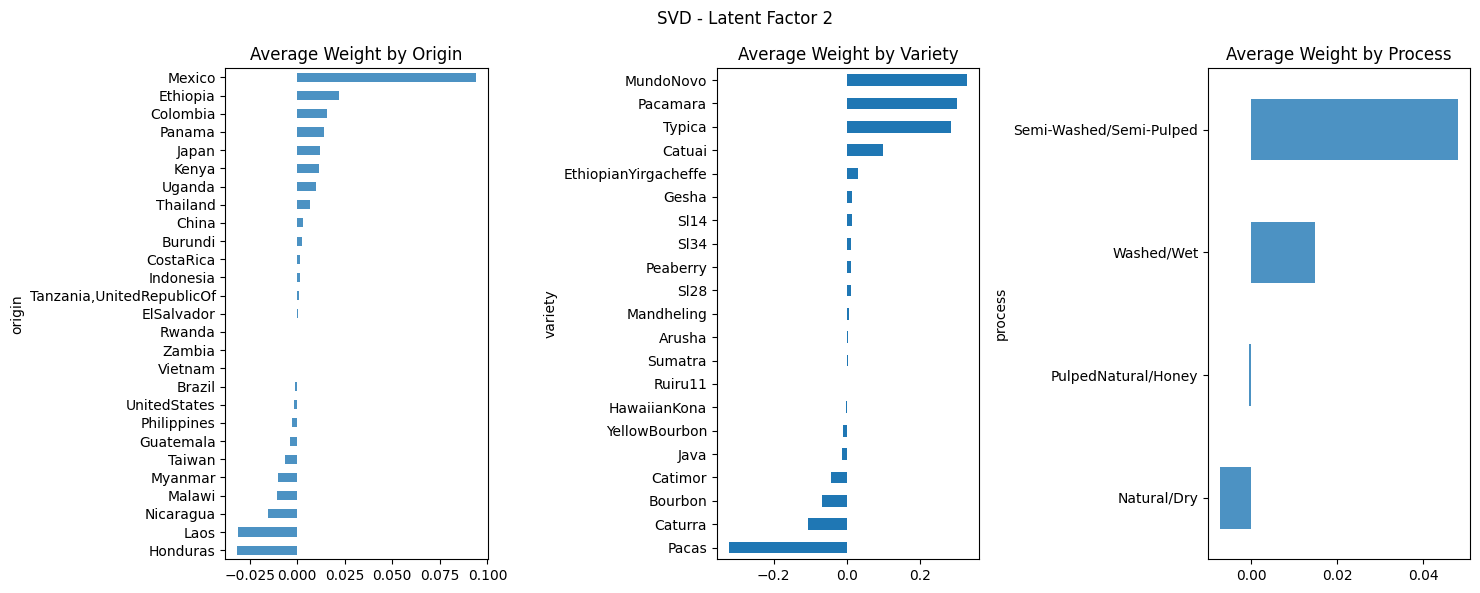


Detailed Statistics:

Top Origin-Variety Combinations:
                                   mean  count
origin   variety                              
Mexico   Pacamara              0.316002      1
         MundoNovo             0.315833      2
         Typica                0.279536      3
         Catuai                0.145699      2
Ethiopia EthiopianYirgacheffe  0.031140      2
Panama   Caturra               0.031140      1
Ethiopia Gesha                 0.016531      1
Colombia Typica                0.015824      2
         Arusha                0.015824      1
         Caturra               0.015791      2


In [167]:
visualize_component_patterns(Vt, idx_to_item, 1, "SVD")

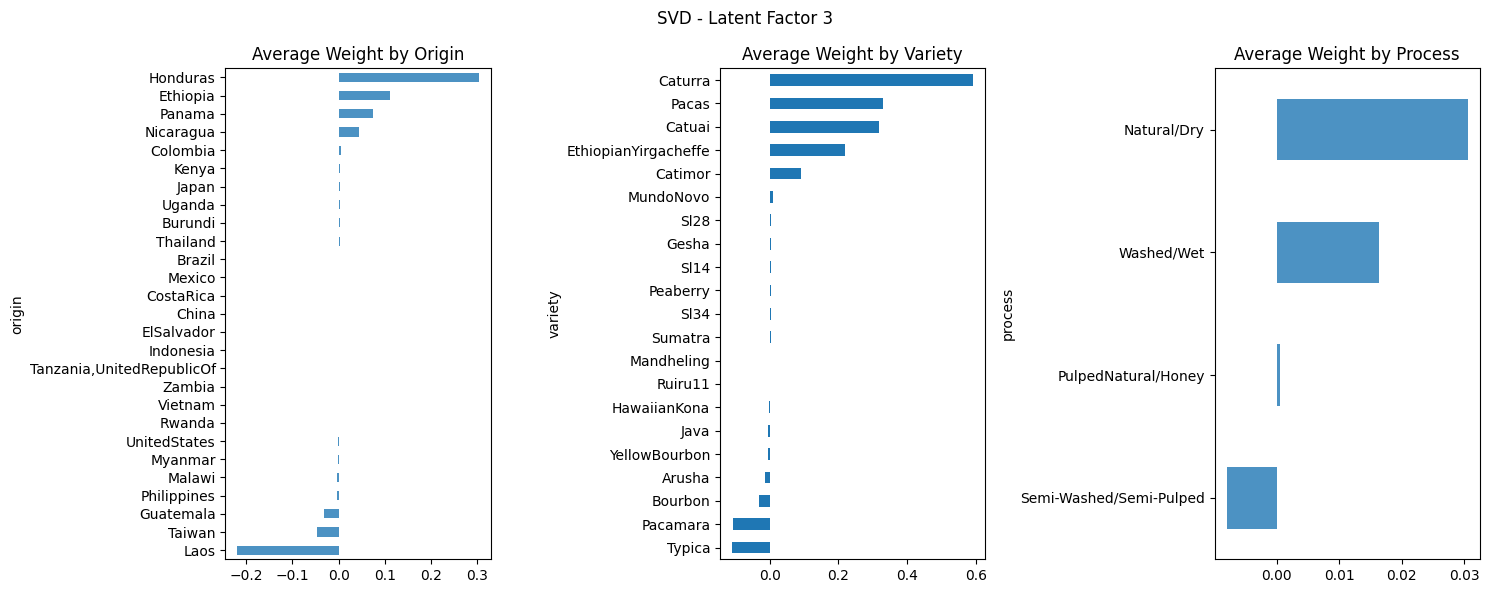


Detailed Statistics:

Top Origin-Variety Combinations:
                                    mean  count
origin    variety                              
Honduras  Caturra               0.303599      2
          Pacas                 0.303599      2
          Catimor               0.303599      1
          Catuai                0.303599      2
Ethiopia  EthiopianYirgacheffe  0.219225      2
Panama    Caturra               0.219225      1
Nicaragua Caturra               0.056442      2
Guatemala Pacas                 0.026307      1
Nicaragua Catuai                0.016167      1
Brazil    Catuai                0.011716      3


In [168]:
visualize_component_patterns(Vt, idx_to_item, 2, "SVD")

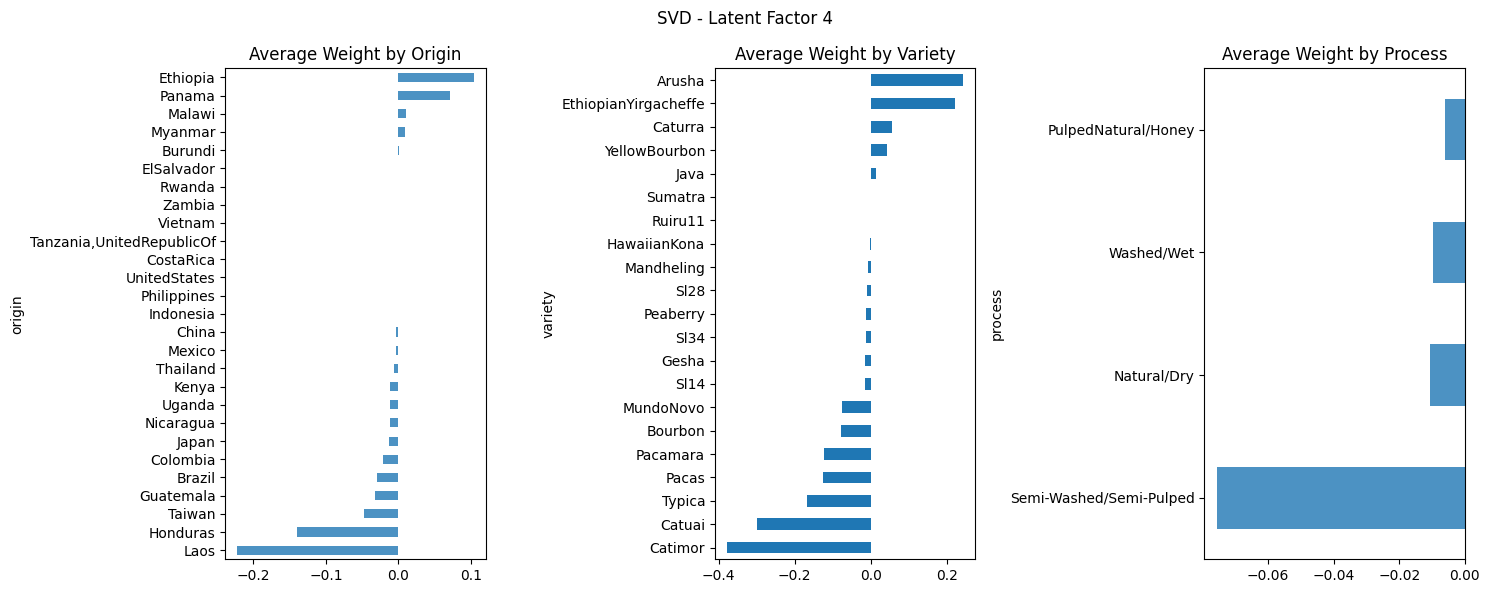


Detailed Statistics:

Top Origin-Variety Combinations:
                                    mean  count
origin    variety                              
Brazil    Arusha                0.272087      1
Ethiopia  EthiopianYirgacheffe  0.222347      2
Panama    Caturra               0.222347      1
Brazil    YellowBourbon         0.044124      4
Indonesia Java                  0.015259      1
          Bourbon               0.015259      1
Mexico    Pacas                 0.012664      1
Malawi    Gesha                 0.010586      1
          Caturra               0.010586      1
Myanmar   Catuai                0.009629      2


In [169]:
visualize_component_patterns(Vt, idx_to_item, 3, "SVD")

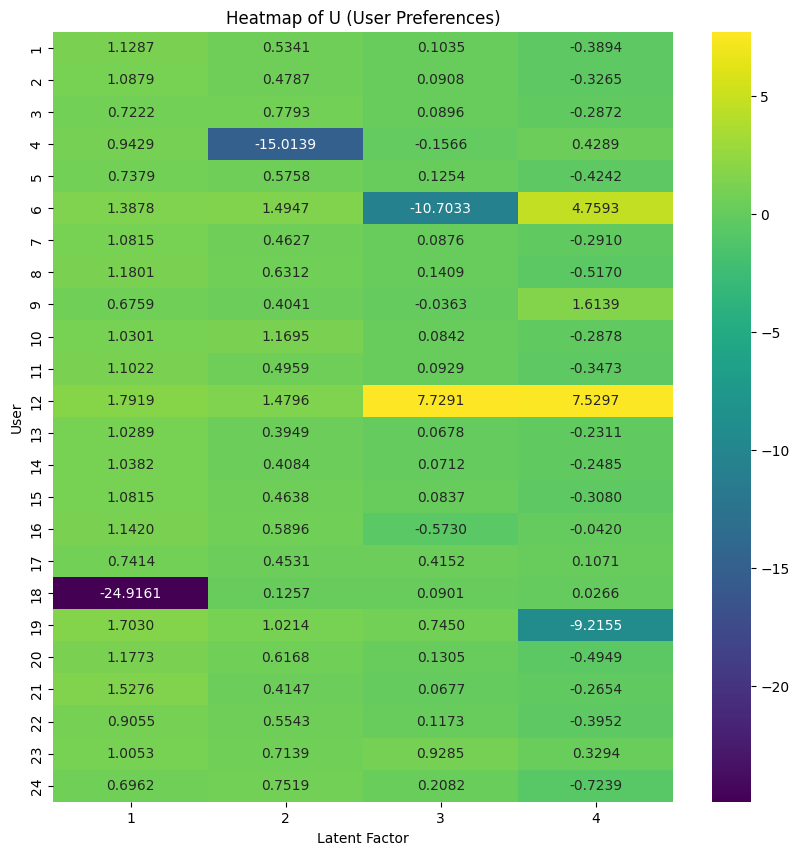

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(U, annot=True, cmap="viridis", fmt=".4f",
            xticklabels=range(1, U.shape[1] + 1),
            yticklabels=range(1, U.shape[0] + 1))
plt.title("Heatmap of U (User Preferences)")
plt.xlabel("Latent Factor")
plt.ylabel("User")
plt.show()

### NMF Latent Factors Analysis

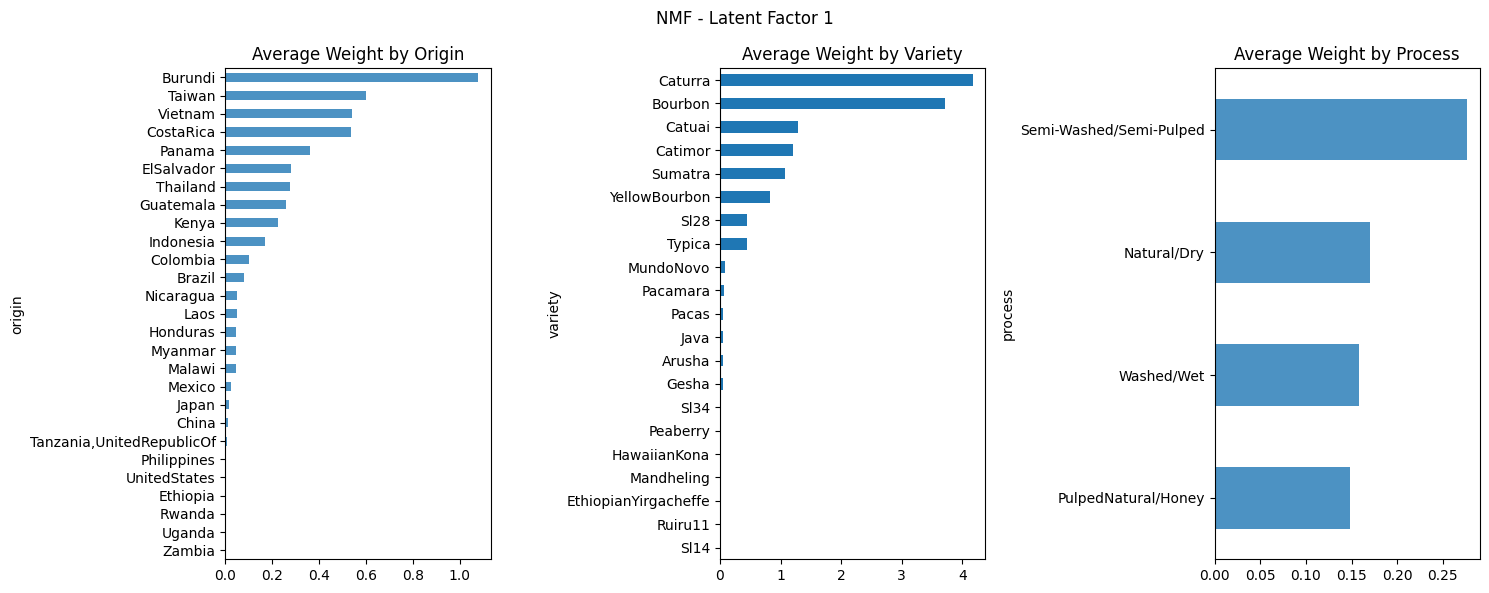


Detailed Statistics:

Top Origin-Variety Combinations:
                             mean  count
origin    variety                       
Panama    Catuai         1.078373      1
Indonesia Sumatra        1.078373      1
Burundi   Bourbon        1.078373      1
Taiwan    Caturra        1.078373      1
          Bourbon        1.078373      2
CostaRica Bourbon        1.078373      1
Vietnam   Catimor        1.078373      1
CostaRica Caturra        1.070118      1
Guatemala Caturra        1.069977      2
Taiwan    YellowBourbon  0.539406      2


In [171]:
visualize_component_patterns(H, idx_to_item, 0, "NMF")

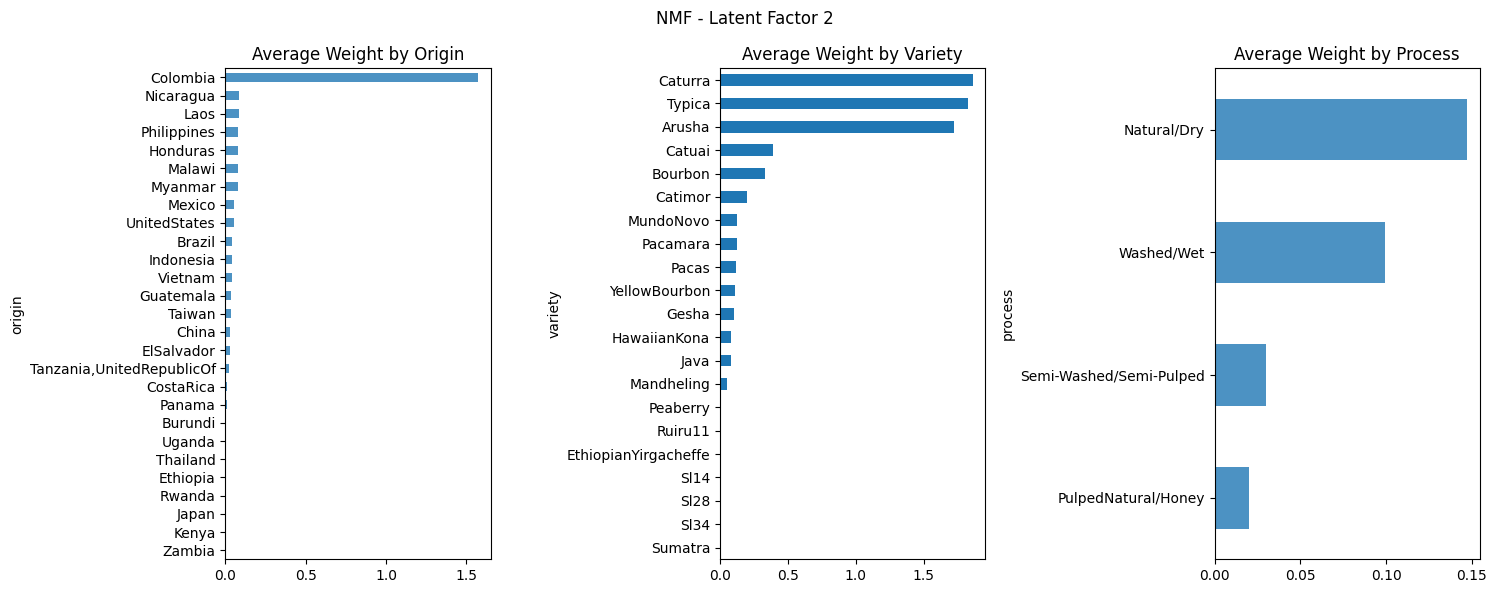


Detailed Statistics:

Top Origin-Variety Combinations:
                               mean  count
origin       variety                      
Colombia     Typica        1.618635      2
             Arusha        1.618635      1
             Caturra       1.506001      2
Nicaragua    Caturra       0.089411      2
Laos         Catimor       0.081582      1
Mexico       Pacamara      0.081570      1
Brazil       Arusha        0.081564      1
UnitedStates HawaiianKona  0.081170      2
Philippines  Typica        0.081170      1
Vietnam      Caturra       0.081170      1


In [172]:
visualize_component_patterns(H, idx_to_item, 1, "NMF")

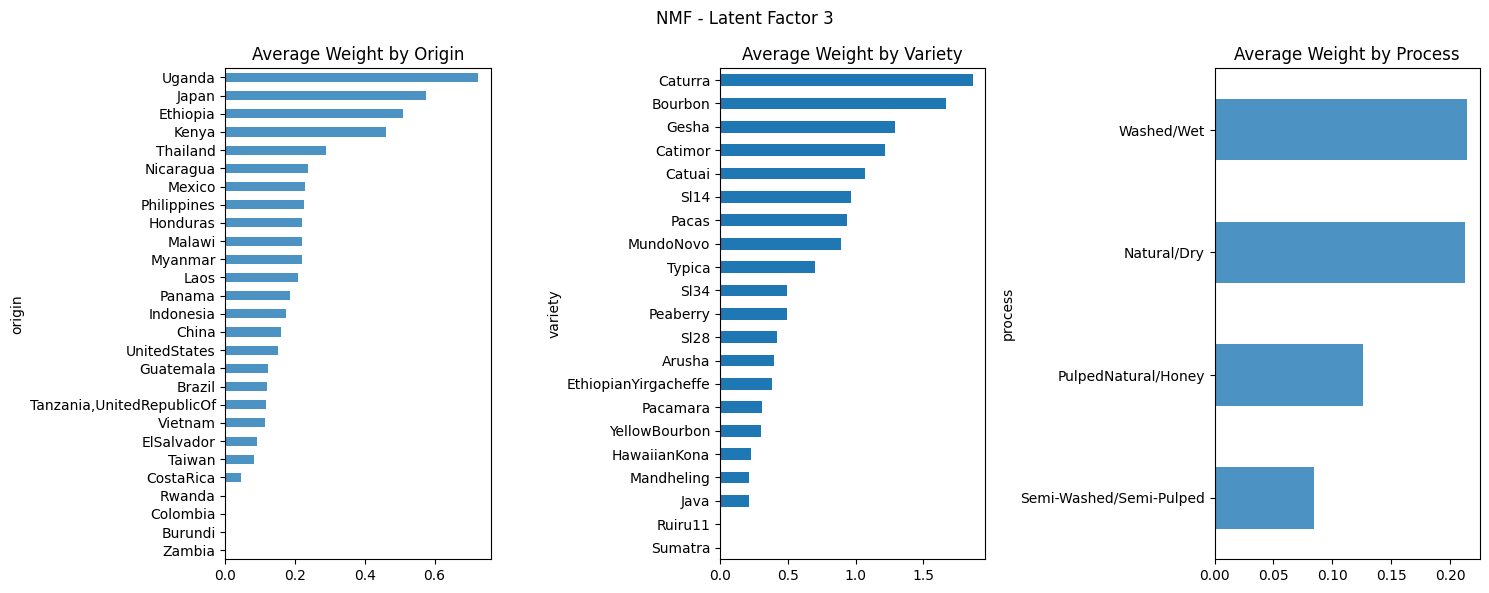


Detailed Statistics:

Top Origin-Variety Combinations:
                                   mean  count
origin   variety                              
Uganda   Sl14                  0.966771      2
Ethiopia Gesha                 0.896729      1
Thailand Catimor               0.574318      2
Japan    MundoNovo             0.574318      1
Kenya    Sl34                  0.497443      1
         Peaberry              0.497443      1
Uganda   Bourbon               0.483386      2
Kenya    Sl28                  0.421459      2
Ethiopia EthiopianYirgacheffe  0.385099      2
Panama   Caturra               0.385099      1


In [173]:
visualize_component_patterns(H, idx_to_item, 2, "NMF")

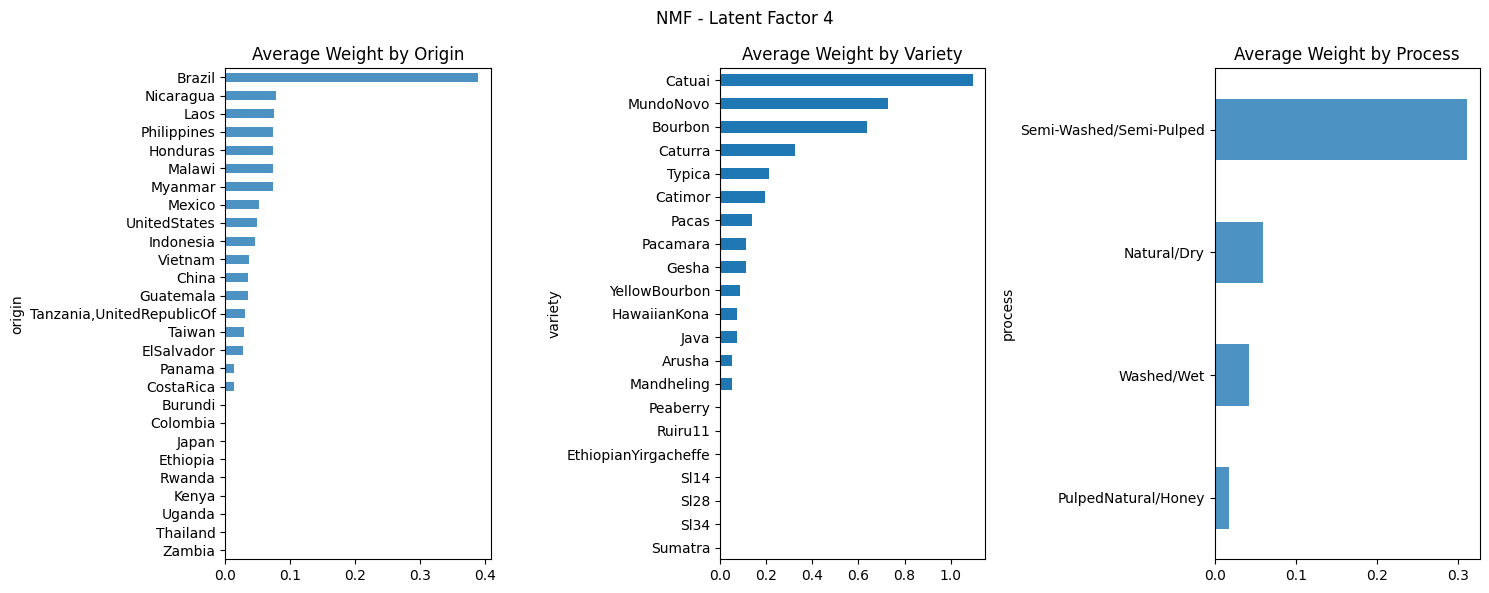


Detailed Statistics:

Top Origin-Variety Combinations:
                               mean  count
origin       variety                      
Brazil       Catuai        0.742203      3
             MundoNovo     0.654683      3
             Bourbon       0.360372      4
Nicaragua    Caturra       0.080835      2
Laos         Catimor       0.074638      1
Mexico       Pacamara      0.074621      1
UnitedStates HawaiianKona  0.074023      2
Philippines  Typica        0.074023      1
Vietnam      Caturra       0.074023      1
Mexico       Catuai        0.073555      2


In [174]:
visualize_component_patterns(H, idx_to_item, 3, "NMF")

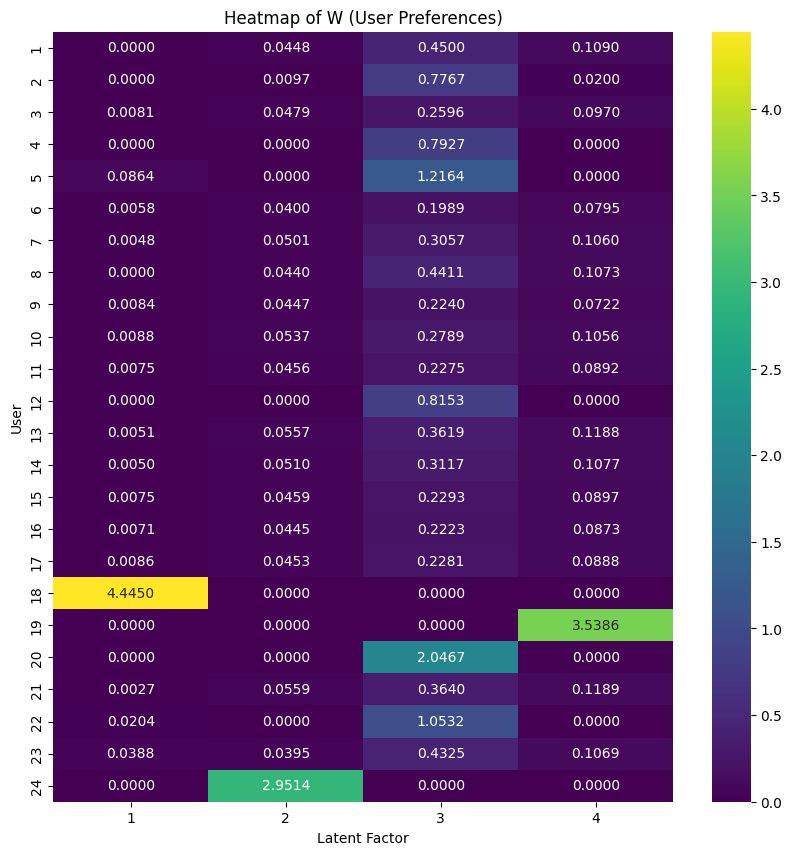

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(W, annot=True, cmap="viridis", fmt=".4f",
            xticklabels=range(1, U.shape[1] + 1),
            yticklabels=range(1, U.shape[0] + 1))
plt.title("Heatmap of W (User Preferences)")
plt.xlabel("Latent Factor")
plt.ylabel("User")
plt.show()